In [1]:
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
import SIR_HUXt_plots as sirplt
import sir_huxt_mono_obs as sir

import astropy.units as u
from astropy.time import Time
import glob
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn

from sklearn.neighbors import KernelDensity
from astropy.time import Time

-2.9499631810589797 deg
False 0-01-01T00:00:00.000 nan d nan deg False
True 2454469.026539593 2.4721399820409715 d 6.283185307179586 rad 105
True 2454469.019862171 2.4654625598341227 d 0.0 rad 105
True 2454469.026539593 2.4721399820409715 d 9.71445146547012e-17 rad 105
False 0-01-01T00:00:00.000 nan d nan deg False


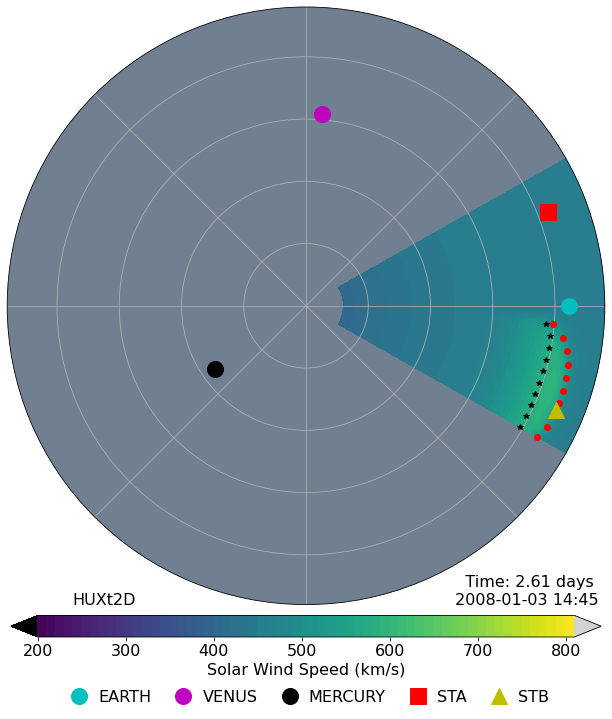

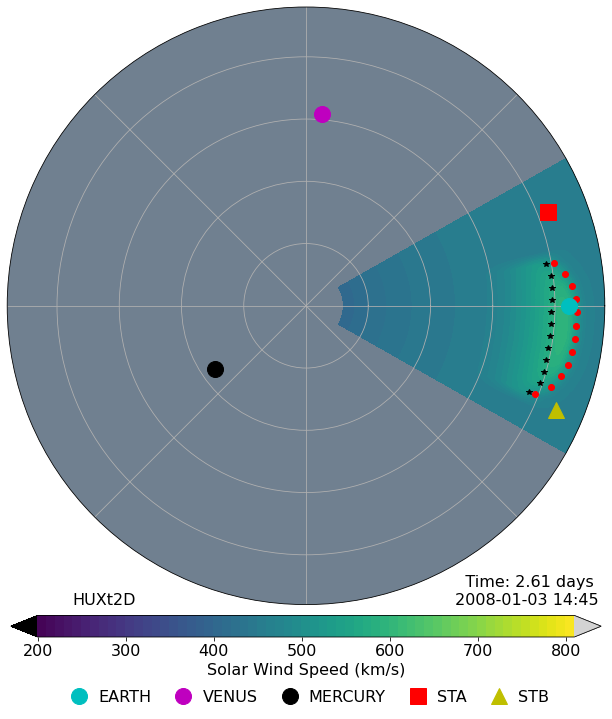

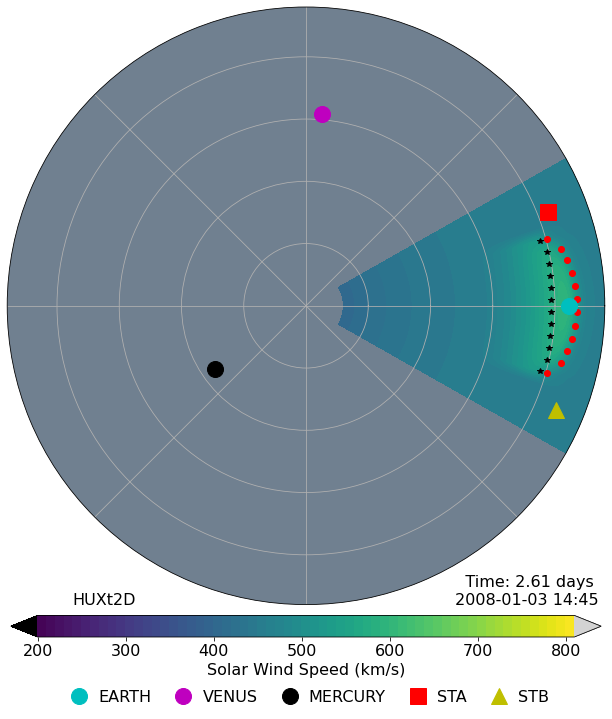

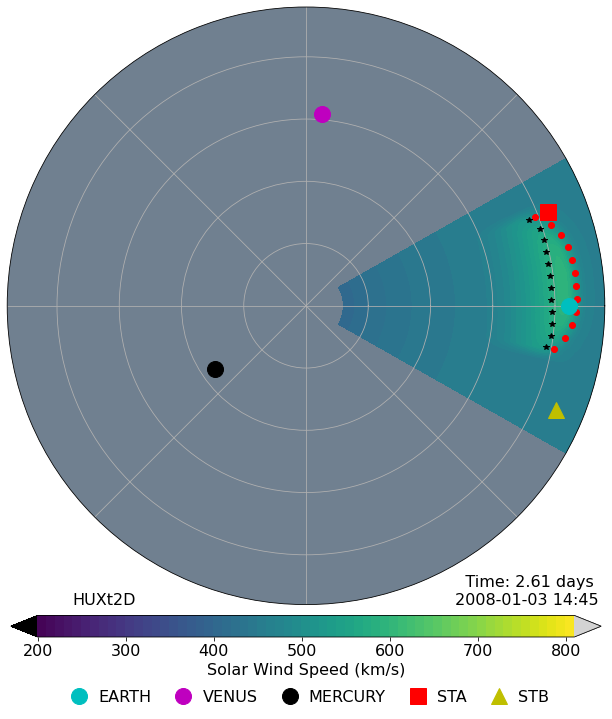

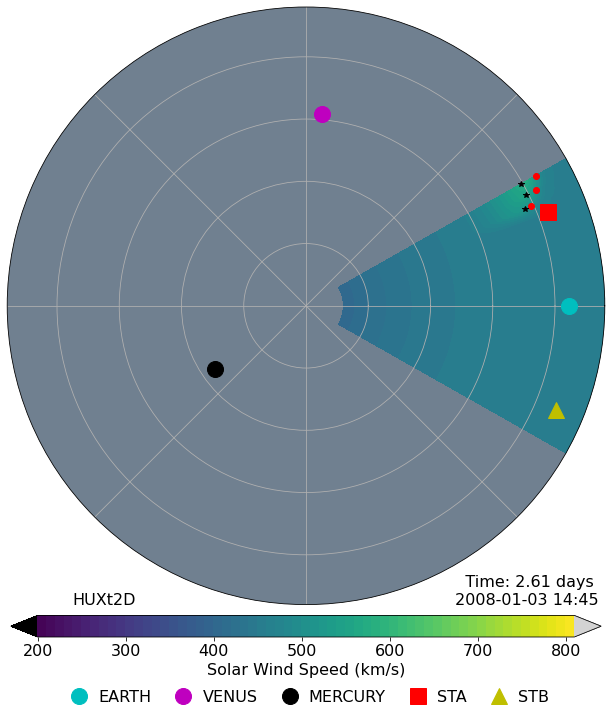

In [4]:
start_time = Time('2008-01-01T00:00:00')
cr_num = np.fix(sn.carrington_rotation_number(start_time))
ert = H.Observer('EARTH', start_time)
vr_in = np.zeros(128) + 400*u.km/u.s
print(ert.lat.to(u.deg))
# Set up HUXt for a 3.5 day simulation, outputting every dt_scale 
model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
               lon_start=330*u.deg, lon_stop=30*u.deg, simtime=4*u.day, dt_scale=4)

# Generate a "truth" CME
base_cme = sir.get_base_cme()

for lon in [-20, -5, 0, 5, 40]:
    base_cme.longitude = lon*u.deg

    # Get HUXt solution of this truth CME, and observations from L5
    model.solve([base_cme])
    cme = model.cmes[0]
    hit, t_a, t_t, hit_lon, hit_id = cme.compute_arrival_at_body('EARTH')
    HA.plot(model, model.time_out[108])
    print(hit, t_a, t_t, hit_lon, hit_id)
    #break


In [3]:
model.frame

'synodic'

In [3]:
# Test the SIR scheme
np.random.seed(19630802)

model = sir.setup_uniform_huxt(dt_scale=14)

# Generate a "truth" CME
base_cme = sir.get_base_cme()

# Get HUXt solution of this truth CME, and observations from L5
model.solve([base_cme])
cme_truth = model.cmes[0]

obs1_lon = -60*u.deg
L5Obs = sir.Observer(model, cme_truth, obs1_lon, el_min=4.0, el_max=30.0)

obs2_lon = 1*u.deg
L1Obs = sir.Observer(model, cme_truth, obs2_lon, el_min=4.0, el_max=30.0)

fig, ax = sirplt.plot_huxt_with_observer(model.time_out[8], model, [L5Obs], add_flank=True, add_fov=True)
fig.savefig('truth_L5.png')
plt.close('all')

fig, ax = sirplt.plot_huxt_with_observer(model.time_out[8], model, [L5Obs, L1Obs], add_flank=True, add_fov=True)
fig.savefig('truth_L1.png')
plt.close('all')

dirs = sir.get_project_dirs()
output_dir = 'sir_multi_obs_test'
output_dir = os.path.join(dirs['sir_analysis'], output_dir)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Run the SIR scheme on this event many times to see how the performance is
n_ens = 5

# Make a guess at the CME initial values 
cme_guess = sir.perturb_cme(base_cme)

# Low observational error
observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.1, cadence=1, el_min=4.0, el_max=30.0)
obs1 = {'observer_lon':obs1_lon, 'observed_cme_flank':observed_cme_flank, 'truth_cme_params':cme_truth.parameter_array()}

observed_cme_flank = L1Obs.compute_synthetic_obs(el_spread=0.1, cadence=1, el_min=4.0, el_max=30.0)
obs2 = {'observer_lon':obs2_lon, 'observed_cme_flank':observed_cme_flank, 'truth_cme_params':cme_truth.parameter_array()}

tag = "multi_obs_run_{:03d}".format(0)
sir.SIR(model, cme_guess, obs1, obs2, n_ens, output_dir, tag)

